# MATH50003 Numerical Analysis: Problem Sheet 2

This week we look at other variants of finite-differences, including central differences and second-order
finite-differences. We also investigate mathematical properties of dual numbers and extend their implementation to
other functions. Finally, we see how dual numbers can be combined with Newton iteration for root finding.

Questions marked with a ⋆ are meant to be completed without using a computer.
Problems are denoted A/B/C to indicate their difficulty.

## 1. Finite-differences

**Problem 1.1⋆ (B)** Use Taylor's theorem to derive an error bound for central differences
$$
f'(x) ≈ {f(x + h) - f(x - h) \over 2h}.
$$
Find an error bound when implemented in floating point arithmetic, assuming that
$$f^{\rm FP}(x) = f(x) + \delta_x$$
where $|\delta_x| \leq c ϵ_{\rm m}$.

**SOLUTION**

By Taylor's theorem, the approximation around $x+h$ is
$$f(x+h) = f(x) + f'(x)h + \frac{f''(x)}{2}h^2 + \frac{f'''(z_1)}{6}h^3,$$
for some $z_1 \in (x, x+h)$ and similarly
$$f(x-h) = f(x) + f'(x)(-h) + \frac{f''(x)}{2}h^2 - \frac{f'''(z_2)}{6}h^3,$$
for some $z_2 \in (x-h, x)$.

Subtracting the second expression from the first we obtain
$$f(x+h)-f(x-h) = f'(x)(2h) + \frac{f'''(z_1)+f'''(z_2)}{6}h^3.$$
Hence,

$$ \frac{f(x+h)-f(x-h)}{2h} = f'(x)  + \underbrace{\frac{f'''(z_1)+f'''(z_2)}{12}h^2}_{δ_{\rm Taylor}}.$$

Thus, the error can be bounded by
$$\left|δ_{\rm Taylor}\right| ≤ {M \over 6} h^2,$$
where
$$
M=\max_{y \in [x-h,x+h]}\left| f'''(y)\right|.
$$

In floating point we have 
$$
\begin{align*}
(f^{\rm FP}(x + 2h) ⊖ f^{\rm FP}(x-2h)) ⊘ (2h) &= {f(x + h) +  δ_{x+h} - f(x-h) - δ_{x-h} \over 2h} (1 + δ_1) \\
&= {f(x+h) - f(x-h) \over 2h} (1 + δ_1) + {δ_{x+h}- δ_{x-h} \over 2h} (1 + δ_1)
\end{align*}
$$
Applying Taylor's theorem we get 
$$
(f^{\rm FP}(x + h) ⊖ f^{\rm FP}(x-h)) ⊘ (2h) = 
f'(x) + \underbrace{f'(x) δ_1 + δ_{\rm Taylor} (1 + \delta_1) + {δ_{x+h}- δ_{x-h} \over 2h} (1 + δ_1)}_{δ_{x,h}^{\rm CD}}
$$
where
$$
|δ_{x,h}^{\rm CD}| ≤ {|f'(x)| \over 2} ϵ_{\rm m} + {M \over 3} h^2 + {2 c ϵ_{\rm m} \over h}
$$


**Problem 1.2 (B)** Implement central differences for $f(x) = 1 + x + x^2$ and $g(x) = 1 + x/3 + x^2$. 
Plot the errors for `h = 2.0 .^ (0:-1:-60)` and `h = 10.0 .^ (0:-1:-16)`. 
Derive the error exactly for the different cases to explain the observed behaviour.

**SOLUTION**

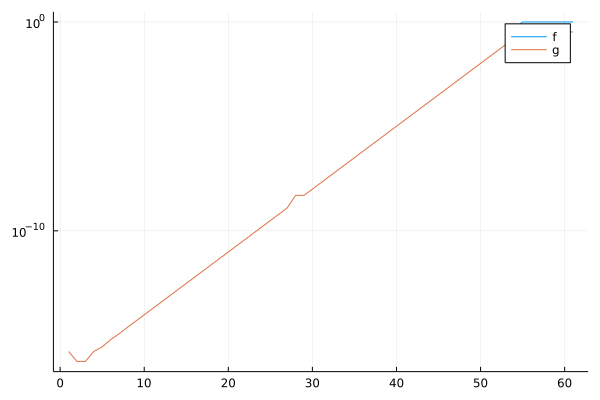

In [1]:
using Plots

# define the functions
f = x -> 1 + x + x^2
g = x -> 1 + x/3 + x^2

# define analytic first derivatives for comparison
fp  = x -> 1 + 2 *x
gp = x ->1/3 + 2 *x

# central difference derivative approximation
centraldiff(x, h, f) = (f(x + h) - f(x - h))/(2 *h)
    
# computes an error
centraldifferror(x, h, f, fp) = abs(centraldiff(x, h, f) - fp(x))

        
#plotting f and g errors   
x = 0.0 # some arbitrary point

# helper function to avoid trying to take logs of 0 in plots
nanabs(x) = iszero(x) ? NaN : abs(x)

# We find the error for the derivative of f is 0 
# (until we run into the errors for too small h we discussed in the lecture)
h = 2.0 .^ (0:-1:-60)
plot(nanabs.(centraldifferror.(x, h, f, fp)), yaxis=:log10, label="f")
plot!(nanabs.(centraldifferror.(x, h, g, gp)), yaxis=:log10, label="g")

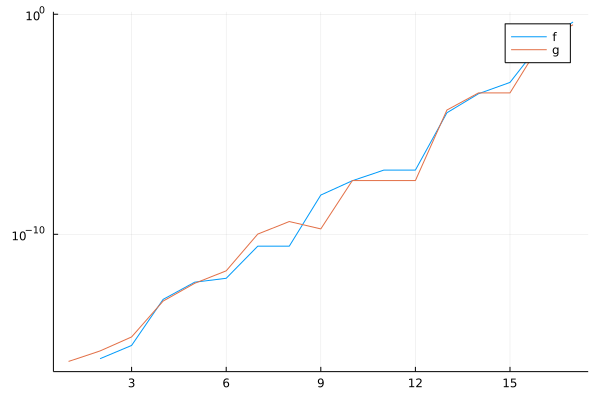

In [2]:
h = 10.0 .^ (0:-1:-16)
plot(nanabs.(centraldifferror.(x, h, f, fp)), yaxis=:log10, label="f")
plot!(nanabs.(centraldifferror.(x, h, g, gp)), yaxis=:log10, label="g")

To compute the errors of the central difference approximation of $f'(x)$ we compute
$$
\begin{align*}
\left| \frac{f(x+h)-f(x-h)}{2h} - f'(x) \right|
&=\left| \frac{1 + (x+h) + (x+h)^2 - 1 - (x-h) - (x-h)^2}{2h} - (1+2x)\right| \\
&=\left| \frac{2h + 4hx}{2h} - 1 -2x\right| = 0.
\end{align*}
$$
As we can see, in this case the central difference approximation is exact. The errors we start observing for small step sizes are thus numerical in nature. The values of the function at $f(x+h)$ and $f(x-h)$ eventually become numerically indistinguishable and thus this finite difference approximation to the derivative incorrectly results in $0$.


To compute the errors of the central difference approximation of $g'(x)$ we compute

$$
\begin{align*}
\left| \frac{g(x+h)-g(x-h)}{2h} - g'(x) \right|&= \left| \frac{1 + \frac{(x+h)}{3} + (x+h)^2 - 1 - \frac{(x-h)}{3} - (x-h)^2}{2h} - \left(\frac{1}{3}+2x \right)\right| \\
&=\left| \frac{1}{3} + 2x - \frac{1}{3} - 2x\right| = 0.
\end{align*}
$$


**Problem 1.3 (A)⋆** Use Taylor's theorem to derive an error bound on the second-order derivative approximation
$$
f''(x) ≈ {f(x+h) - 2f(x) + f(x-h) \over h^2}
$$
Find an error bound when implemented in floating point arithmetic, assuming that
$$
f^{\rm FP}(x) = f(x) + δ_x
$$
where $|δ_x| \leq c ϵ_{\rm m}$.

**SOLUTION**

Using the same two formulas as in 1.1 we have
$$f(x+h) = f(x) + f'(x)h + \frac{f''(x)}{2}h^2 + \frac{f'''(z_1)}{6}h^3,$$
for some $z_1 \in (x, x+h)$
and
$$f(x-h) = f(x) + f'(x)(-h) + \frac{f''(x)}{2}h^2 - \frac{f'''(z_2)}{6}h^3,$$
for some $z_2 \in (x-h, x)$.

Summing the two we obtain
$$f(x+h) + f(x-h) = 2f(x) + f''(x)h^2 + \frac{f'''(z_1)}{6}h^3 - \frac{f'''(z_2)}{6}h^3.$$

Thus,
$$f''(x) = \frac{f(x+h) - 2f(x) + f(x-h)}{h^2} + \frac{f'''(z_2) - f'''(z_1)}{6}h.$$

Hence, the error is 
$$
\left|f''(x) - \right| = \left|\frac{f'''(z_2) - f'''(z_1)}{6}h\right|≤ 2Ch ,
$$
where again
$$C = \max_{y∈[x-h,x+h]}\left|\frac{f'''(y)}{6}\right|.$$

In floating point arithmetic we assume $x + h = x ⊕ h$, $h$ is a power of $2$ and all computations are normal. 
Then we have:
$$
f^{\rm FP}(x + h) \ominus 2f^{\rm FP}(x) = (f(x+h) + δ_{x+h} - 2f(x) -2δ_x)(1+δ^1) = f(x+h) - 2f(x) + \underbrace{(f(x+h) - 2f(x))δ^1 + (δ_{x+h} - 2 δ_x)(1+δ^1)}_{δ^2}
$$
where $|δ^2| ≤ (3/2F + 4c) ϵ_m$, where $F = \sup_{x-h ≤ t ≤ x+h} |f(t)|$. Therefore
$$
(f^{\rm FP}(x + h) \ominus 2f^{\rm FP}(x)) ⊕ f^{\rm FP}(x - h) = ((f(x+h) - 2f(x) + δ^2) + f(x-h) + δ_{x-h})(1+δ^3) = f(x+h) - 2f(x) + f(x-h) + \underbrace{(f(x+h) - 2f(x) + f(x-h)) δ^3 + (δ^2 + δ_{x-h})(1+δ^3)}_{δ^4}
$$
where $|δ^4| ≤ (5F + 10c)ϵ_{\rm m}$. Putting everything together we have
$$
{(f^{\rm FP}(x + h) \ominus 2f^{\rm FP}(x)) ⊕ f^{\rm FP}(x - h) \over h} = {f(x+h) - 2f(x) + f(x-h) \over h^2} + {δ^4 \over h^2} = f''(x) + \frac{f'''(z_2) - f'''(z_1)}{6}h +  {δ^4 \over h^2} 
$$
that is the error is bounded by
$$
2Ch + (5F + 10c){ϵ_{\rm m} \over h^2}
$$

**Problem 1.4 (B)** Use finite-differences, central differences, and second-order finite-differences to approximate to 5-digits the first and second 
derivatives to the following functions
at the point $x = 0.1$:
$$
\exp(\exp x \cos x + \sin x), \prod_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x)
$$
where $f^{\rm s}_n(x)$ corresponds to $n$-terms of the following continued fraction:
$$
1 + {x-1 \over 2 + {x-1 \over 2 + {x-1 \over 2 + \ddots}}},
$$
e.g.:
$$f^{\rm s}_1(x) = 1 + {x-1 \over 2}$$
$$f^{\rm s}_2(x) = 1 + {x-1 \over 2 + {x -1 \over 2}}$$
$$f^{\rm s}_3(x) = 1 + {x-1 \over 2 + {x -1 \over 2 + {x-1 \over 2}}}$$


**SOLUTION**

In [3]:
# Forward Difference
forwarddiff(x, h, f) = (f(x + h) - f(x))/h

# We already implemented central differences in a previous problem

# Second derivative via finite difference
finitediffsecond(x, h, f) = (f(x + h) - 2 * f(x) + f(x - h))/ (h^2)
    
# Define the functions
f = x -> exp(exp(x)cos(x) + sin(x))
g = x -> prod([x] ./ (1:1000) .- 1)
function cont(n, x)
    ret = 2*one(x)
    for k = 1:n-1
        ret = 2 + (x-1)/ret
    end
    1 + (x-1)/ret
end

# Choose our point
x = 0.1;

In [4]:
# We have to be a bit careful with the choice of h
h = eps()
# Values for exp(exp(x)cos(x) + sin(x))
println("f'($x) with forward difference: ", forwarddiff(x, sqrt(h), f))
println("f'($x) with central difference: ", centraldiff(x, cbrt(h), f))
println("f''($x) via finite difference:  ", finitediffsecond(x, cbrt(h), f))

f'(0.1) with forward difference: 6.584772557020187
f'(0.1) with central difference: 6.5847725545726465
f''(0.1) via finite difference:  12.002673711904597


In [5]:
# Values for prod([x] ./ (1:1000) .- 1)
println("f'($x) with forward difference: ", forwarddiff(x, sqrt(h), g))
println("f'($x) with central difference: ", centraldiff(x, cbrt(h), g))
println("f''($x) via finite difference:  ", finitediffsecond(x, cbrt(h), g))

f'(0.1) with forward difference: -3.5938263945281506
f'(0.1) with central difference: -3.5938265143048937
f''(0.1) via finite difference:  26.638555736977985


In [6]:
# Values for the continued fraction
println("f'($x) with forward difference: ", forwarddiff(x, sqrt(h), x->cont(1000,x)))
println("f'($x) with central difference: ", centraldiff(x, sqrt(h), x->cont(1000,x)))
println("f''($x) via finite difference:  ", finitediffsecond(x, cbrt(h), x->cont(1000,x)))

f'(0.1) with forward difference: 1.5811387598514557
f'(0.1) with central difference: 1.5811388231813908
f''(0.1) via finite difference:  -7.905698560322122


## 2. Dual numbers

**Problem 2.1⋆ (C)** 
Show that dual numbers $\mathbb{D}$ are a _commutative ring_, that is, for all $a,b,c \in \mathbb{D}$ the following are satisfied:
1. _additive associativity_: $(a + b) + c = a + (b + c)$
2. _additive commutativity_: $a + b = b + a$
3. _additive identity_: There exists $0 ∈ \mathbb{D}$ such that $a + 0 = a$.
4. _additive inverse_: There exists $-a$ such that $(-a) + a = 0$.
5. _multiplicative associativity_: $(ab)c = a(bc)$
6. _multiplictive commutativity_: $ab = ba$
7. _multiplictive identity_: There exists $1 ∈ \mathbb{D}$ such that $1a= a$.
8. _distributive_: $a(b+c) = ab + ac$

**SOLUTION**
In what follows we write $a = a_r + a_d ϵ$ and likewise for $b,c \in \mathbb{D}$.

Additive associativity and commutativity and existence of additive inverse are both 
immediate results of dual number addition reducing to element-wise real number addition. 
Furthermore, by definition of addition on $\mathbb{D}$ the dual number $0+0 ϵ$ acts as the additive 
identity since
$$
(a_r+a_dϵ)+(0+0ϵ) = (a_r+a_dϵ ).
$$
We explicitly prove multiplicative commutativity
$$
ab = (a_r+a_dϵ )(b_r+b_d ϵ ) = a_r b_r+(a_r b_d+a_d b_r)ϵ = b_r a_r+(b_r a_d+b_d a_r)ϵ = ba.
$$
We also explicitly prove multiplicative associativity:
$$
(ab)c = ((a_r b_r+(a_r b_d+a_d b_r) ϵ ) c = 
a_r b_r c_r + ((a_r b_d + a_d b_r) c_r  + a_r b_r c_d) ϵ = 
a_r b_r c_r + (a_r b_d c_r + a_d b_r c_r  + a_r b_r c_d) ϵ
$$
and
$$
a(bc) = a ((b_r c_r+(b_r c_d+b_d c_r) ϵ ) = a_r b_r c_r + (a_r b_d c_r + a_d b_r c_r  + a_r b_r c_d) ϵ.
$$
The number $1+0ϵ$ serves as the multiplicative identity. Note that for any dual number $a$, we have
$$
(1+0ϵ )(a_r + a_d ϵ ) = 1 a_r + (a_r 0 + 1 a_d) ϵ = a_r+a_d ϵ = a.
$$
Finally we show distributivity of multiplication:
$$
a(b+c) = a (b_r+c_r + (b_d+c_d)ϵ) = (a_r b_r + a_r c_r) + (a_r b_d+a_r c_d+ a_d b_r + a_d c_r) ϵ,
$$
$$
ab + ac = a_r b_r + (a_d b_r + a_r b_d) ϵ + a_r c_r + (a_d c_r + a_r c_d) ϵ = (a_r b_r + a_r c_r) + (a_r b_d+a_r c_d+ a_d b_r + a_d c_r) ϵ.
$$


**Problem 2.2⋆ (C)** A _field_ is a commutative ring such that $0 ≠ 1$ and all nonzero elements have a multiplicative inverse, i.e.,
there exists $a^{-1}$ such that $a a^{-1} = 1$. Why isn't $\mathbb{D}$ a field?

**SOLUTION**

Fields require that all nonzero elements have a unique multiplicative inverse. However, this is not the case for dual numbers. To give an explicit counter example, we show that there is no dual number $z$ which is the inverse of $0+ϵ$, i.e. a dual number $z$ such that
$$
\frac{(0+ϵ)}{(z_r+z_d ϵ)} = 1 + 0 ϵ.
$$
By appropriate multiplication with the conjugate we show that
$$
\frac{(0+ϵ)(z_r-z_d ϵ)}{(z_r+z_d ϵ)(z_r-z_d ϵ)} = \frac{z_r ϵ}{z_r^2} = \frac{ϵ}{z_r}.
$$
This proves that no choice of real part $z_r$ can reach the multiplicative identity $1+0 ϵ$ when starting from the number $0+ϵ$. More general results for zero real part dual numbers can also be proved.
 
**Problem 2.3⋆ (B)** A _matrix representation_ of a ring are maps from a group/ring to matrices such that matrix addition and multiplication
behave exactly like addition and multiplication of the ring. 
That is, if $A$ and $B$ are elements of the ring and $ρ$ is a representation, then
$$
ρ(A + B) = ρ(A) + ρ(B) \hbox{ and } ρ(AB) = ρ(A)ρ(B).
$$
Show that the following are matrix representations of complex numbers and dual numbers (respectively):
$\rho : a + b {\rm i} \mapsto \begin{pmatrix} a & b \\ -b & a \end{pmatrix},$

$\rho_ϵ : a + b {\rm ϵ} \mapsto \begin{pmatrix} a & b \\ 0 & a \end{pmatrix}.$

**SOLUTION**

Let $A = a+bi$ and $B=c+di$ and $\rho$ be the map to their proposed matrix representations. First we check that addition complies with addition of complex numbers, that is 
$(a+bi)+(c+di) = (a+c)+(b+d)i:$
 
$\rho(A) + \rho(B) = \begin{pmatrix} a & b \\ -b & a \end{pmatrix} + \begin{pmatrix} c & d \\ -d & c \end{pmatrix} = \begin{pmatrix} a+c & b+d \\ -(b+d) & a+c \end{pmatrix} = \rho(A+B).$

Next for multiplication we need $(a+bi)(c+di) = (ac-bd)+(bc+ad)i $:

$\rho(A)\rho(B) = \begin{pmatrix} a & b \\ -b & a \end{pmatrix}\begin{pmatrix} c & d \\ -d & c \end{pmatrix} = \begin{pmatrix} ac-bd & bc+ad \\ -(bc+ad) & ac-bd \end{pmatrix} = \rho(AB)$

Now we move on to dual numbers $A = a+b ϵ $ and $B=c+d ϵ$ and their matrix representation map $\rho_ϵ$: For addition of dual numbers $(a+bϵ )+(c+dϵ ) = (a+c) + (b+d) ϵ$:

$\rho_ϵ(A) + \rho_ϵ(B) = \begin{pmatrix} a & b \\ 0 & a \end{pmatrix} + \begin{pmatrix} c & d \\ 0 & c \end{pmatrix} = \begin{pmatrix} a+c & b+d \\ 0 & a+c \end{pmatrix} = \rho_ϵ(A+B).$

And finally for multiplication of dual numbers $(a+bϵ )(c+dϵ ) = ac+(ad+bc)ϵ$:

$\rho_ϵ(A)\rho_ϵ(B) = \begin{pmatrix}a & b \\ 0 & a \end{pmatrix}\begin{pmatrix} c & d \\ 0 & c \end{pmatrix} = \begin{pmatrix} ac & ad+bc \\ 0 & ac \end{pmatrix} = \rho_ϵ(AB).$


**Problem 2.4⋆ (C)** What is the correct definition of division on dual numbers, i.e.,
$$
(a + b ϵ )/(c + d ϵ ) = s + t ϵ
$$
for what choice of $s$ and $t$? Use dual numbers to compute the derivative of the following functions at $x = 0.1$:
$$
\exp(\exp x \cos x + \sin x), \prod_{k=1}^3 \left({x \over k}-1\right),\hbox{ and } f^{\rm s}_2(x) = {1 + {x - 1 \over 2 + {x-1 \over 2}}}
$$

**SOLUTION**

As with complex numbers, division is easiest to understand by first multiplying with the conjugate, that is:
$$
\frac{a+bϵ}{c+dϵ} = \frac{(a+bϵ)(c-dϵ)}{(c+dϵ)(c-dϵ)}.
$$
Expanding the products and dropping terms with $ϵ^2$ then leaves us with the definition of division for dual numbers (where the denominator must have non-zero real part):
$$
\frac{a}{c} + \frac{bc - ad}{c^2}ϵ.
$$ 
Thus we have $s = \frac{a}{c}$ and $t = \frac{bc - ad}{c^2}$.

We now compute the derivatives of the three functions by evaluating for $x = 0.1 + ϵ$.

For the first function we have:
$$
\begin{align*}
\exp(\exp(0.1 + ϵ)\cos(0.1+ϵ) + \sin(0.1+ϵ)) &=
\exp((\exp(0.1) + ϵ\exp(0.1))(\cos(0.1)-\sin(0.1)ϵ) + \sin(0.1)+\cos(0.1)ϵ) \\
&= \exp(\exp(0.1)\cos(0.1)+ \sin(0.1) + (\exp(0.1)(\cos(0.1)-\sin(0.1))+\cos(0.1))ϵ) \\
&= \exp(\exp(0.1)\cos(0.1)+ \sin(0.1)) + \exp(\exp(0.1)\cos(0.1)+ \sin(0.1))\exp(0.1)(\cos(0.1)-\sin(0.1))+\cos(0.1))ϵ 
\end{align*}
$$
therefore the derivative is the dual part
$$
\exp(\exp(0.1)\cos(0.1)+ \sin(0.1))(\exp(0.1)(\cos(0.1)-\sin(0.1))+\cos(0.1))
$$

For the second function we have:
$$
\begin{align*}
 \left(0.1+ϵ-1\right) \left({0.1 + ϵ \over 2}-1\right)\left({0.1 + ϵ \over 3}-1\right)
 &=\left(-0.9+ϵ\right) \left(-0.95 + ϵ/2\right)\left(-29/30 + ϵ/3\right) \\
&=\left(171/200 -1.4ϵ\right)\left(-29/30 + ϵ/3\right)  \\
&= -1653/2000 + 983ϵ/600
\end{align*}
$$
Thus the derivative is $983/600$.

For the third function we have:
$$
\begin{align*}
{1 + {0.1+ϵ - 1 \over 2 + {0.1+ϵ-1 \over 2}}} &=  {1 + {-0.9+ϵ \over 1.55 + ϵ/2}}\\
&= 1 -18/31 + 2ϵ/1.55^2
\end{align*}
$$
Thus the derivative is $2/1.55^2$.

**Problem 2.5 (C)** Add support for `cos`, `sin`, and `/` to the type `Dual`:

In [7]:
# Dual(a,b) represents a + b*ϵ
struct Dual{T}
    a::T
    b::T
end

# Dual(a) represents a + 0*ϵ
Dual(a::Real) = Dual(a, zero(a)) # for real numbers we use a + 0ϵ

# Allow for a + b*ϵ syntax
const ϵ = Dual(0, 1)

import Base: +, *, -, /, ^, zero, exp, cos, sin, one

# support polynomials like 1 + x, x - 1, 2x or x*2 by reducing to Dual
+(x::Real, y::Dual) = Dual(x) + y
+(x::Dual, y::Real) = x + Dual(y)
-(x::Real, y::Dual) = Dual(x) - y
-(x::Dual, y::Real) = x - Dual(y)
*(x::Real, y::Dual) = Dual(x) * y
*(x::Dual, y::Real) = x * Dual(y)

# support x/2 (but not yet division of duals)
/(x::Dual, k::Real) = Dual(x.a/k, x.b/k)

# a simple recursive function to support x^2, x^3, etc.
function ^(x::Dual, k::Integer)
    if k < 0
        error("Not implemented")
    elseif k == 1
        x
    else
        x^(k-1) * x
    end
end

# support identity of type Dual
one(x::Dual) = Dual(one(eltype(x.a)))

# Algebraic operations for duals
-(x::Dual) = Dual(-x.a, -x.b)
+(x::Dual, y::Dual) = Dual(x.a + y.a, x.b + y.b)
-(x::Dual, y::Dual) = Dual(x.a - y.a, x.b - y.b)
*(x::Dual, y::Dual) = Dual(x.a*y.a, x.a*y.b + x.b*y.a)

exp(x::Dual) = Dual(exp(x.a), exp(x.a) * x.b)

function cos(x::Dual)
    # TODO: implement cos for Duals
    ## SOLUTION
    Dual(cos(x.a), -sin(x.a) * x.b)
    ## END
end

function sin(x::Dual)
    # TODO: implement sin for Duals
    ## SOLUTION
    Dual(sin(x.a), cos(x.a) * x.b)
    ## END
end

function /(x::Dual, y::Dual)
    # TODO: implement division for Duals
    ## SOLUTION
    if iszero(y.a)
        error("Division for dual numbers is ill-defined when denonimator real part is zero.")
    end
    return Dual(x.a / y.a, (y.a * x.b - x.a * y.b) / y.a^2)
    ## END
end

/ (generic function with 136 methods)

**Problem 2.6 (B)** Use dual numbers to compute the derivatives to
$$
\exp(\exp x \cos x + \sin x), \prod_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x).
$$
Does your answer match (to 5 digits) Problem 1.4?

**SOLUTION**

With the previous problems solved, this is as simple as running

In [8]:
fdual = f(0.1+ϵ)
fdual.b

6.5847725546108276

In [9]:
gdual = g(0.1+ϵ)
gdual.b

-3.593826513101571

In [10]:
contdual = cont(1000,0.1+ϵ)
contdual.b

1.5811388300841893

## 3. Newton iteration

Newton iteration is an algorithm for computed roots of a function $f$ using its derivative: given an initial guess $x_0$, one
obtains a sequence of guesses via
$$
x_{k+1} = x_k - {f(x_k) \over f'(x_k)}
$$

**Problem 3.1 (B)** Use `Dual` to implement the following function which returns $x_n$:

In [11]:
function newton(f, x0, n)
    ## TODO: compute x_n 
    ## SOLUTION
    xk = x0
    for k = 1:n
        fd = f(xk + ϵ)
        xk = xk - fd.a / fd.b
    end
    return xk
    ## END
end

newton (generic function with 1 method)

**SOLUTION**

Here is a simple test case for the above function:

In [12]:
# example
f_ex(x) = x^2-3
n = 5
x0 = 1
# compute proposed root
xn = newton(f_ex,x0,n) 
# check that obtained point is an approximate root
f_ex(xn)

-4.440892098500626e-16

**END**


**Problem 3.2 (B)** Compute points $y$ such that $|f(y)| \leq 10^{-13}$ (i.e., approximate roots):
$$
\exp(\exp x \cos x + \sin x)-6\hbox{ and } \prod_{k=1}^{1000} \left({x \over k}-1\right) - {1 \over 2}
$$
(Hint: you may need to try different `x0` and `n` to get convergence. Plotting the function should give an
indication of a good initial guess.)

**SOLUTION**

We can plot the functions on a few ranges to get an intuition

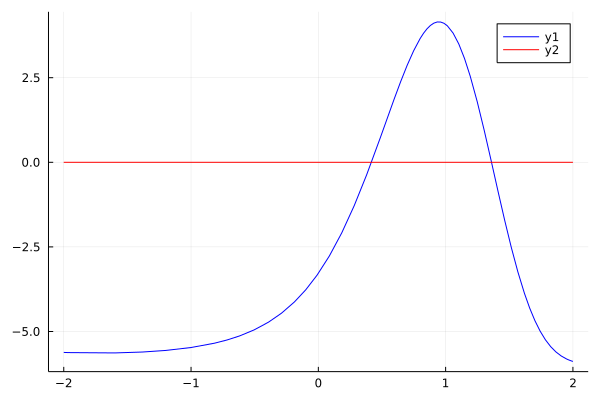

In [13]:
using Plots

f1(x) = exp(exp(x)*cos(x) + sin(x)) - 6
f2(x) = prod([x] ./ range(1,1000) .- 1) - 1/2

plot(f1,-2,2,color="blue")
plot!(x->0,color="red")

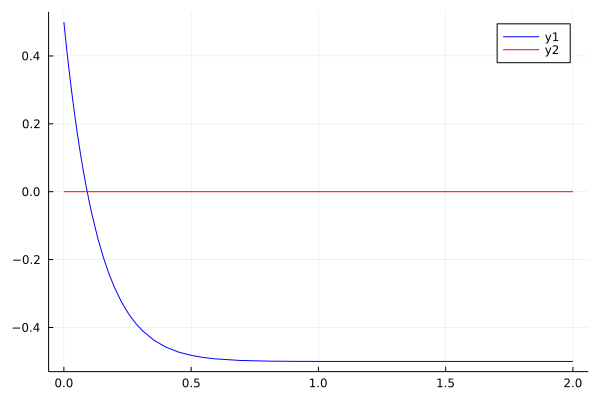

In [14]:
plot(f2,0,2,color="blue")
plot!(x->0,color="red")

And then use our Newton iteration to compute approximate roots

In [15]:
rootf1 = newton(f1, 1.5, 5)
f1(rootf1)

0.0

In [16]:
rootf2 = newton(f2, 0.3, 8)
f2(rootf2)

7.771561172376096e-16

**Problem 3.3 (A)** Compute points $y$ such that $|f^{\rm s}_{1000}(y) - j| \leq 10^{-13}$ for $j = 1,2,3$. 
Make a conjecture of what $f^{\rm s}_n(x)$ converges to as $n → ∞$. (Bonus problem: Prove your conjecture.)

**SOLUTION**

In [17]:
xn = newton(x->cont(1000,x)-1.,0.5,10)
cont(1000,xn)-1.

0.0

In [18]:
xn = newton(x->cont(1000,x)-2.,0.5,10)
cont(1000,xn)-2.

0.0

In [19]:
xn = newton(x->cont(1000,x)-3.,0.5,10)
cont(1000,xn)-3.

0.0

By plotting the function we can conjecture that the continued fraction converges to $\sqrt{x}$:

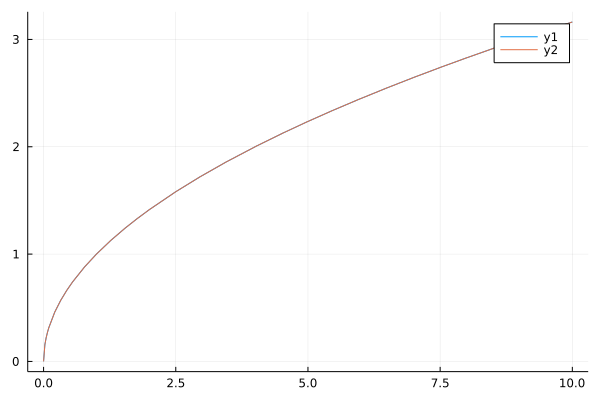

In [20]:
using Plots
plot(x->cont(1000,x),0,10)
plot!(x->sqrt(x))

There are a handful of ways to prove this conjecture. Here is one - start with

$$ \sqrt{x}(1+\sqrt{x}) = \sqrt{x}+x,$$

then extend the RHS by $0 = +1-1$ to also obtain the factor $1+\sqrt{x}$ there, resulting in

$$ \sqrt{x}(1+\sqrt{x}) = (1+\sqrt{x})+x-1.$$

Dividing through $(1+\sqrt{x})$ now yields

$$ \sqrt{x} = 1 + \frac{x-1}{1+\sqrt{x}}.$$

Note that we can now plug this equation into itself on the right hand side to obtain a recursive continued fraction for the square root function.